# Purpose

This notebook compares return and volatility forecasting models, summarises their relative performance, and highlights implications for financial decision-making.

All forecasts are evaluated at a one-step-ahead horizon using out-of-sample data from 2022–2024.

# Imports and configuration

In [1]:
import sys
from pathlib import Path

project_root = Path("..").resolve()
if str(project_root) not in sys.path:
    sys.path.insert(0, str(project_root))

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import mean_absolute_error, root_mean_squared_error

from src.evaluation import regression_metrics, naive_volatility_metrics


# Load model outputs

## Reutrns

In [8]:
returns_df = pd.read_csv(
    "../data/processed/daily_returns.csv",
    index_col=0,
    parse_dates=True
)
returns_df.index = pd.to_datetime(returns_df.index, format="%d/%m/%Y", errors="raise")
returns_df = returns_df.sort_index()

returns = returns_df["adj_log_return"]

In [11]:
# Baseline mean
split_date = "2022-01-01"
train_returns = returns.loc[:split_date]
test_returns = returns.loc[split_date:]

baseline_return_forecast = pd.Series(
    train_returns.mean(),
    index=test_returns.index
)

In [12]:
# ARIMA forecasts
arima_forecasts = pd.read_csv(
    "../outputs/forecasts/arima_return_forecast.csv",
    index_col=0,
    parse_dates=True
).squeeze()

## Volatility

In [9]:
# Realised volatility
vol_df = pd.read_csv(
    "../data/processed/realised_volatility_21d.csv",
    index_col=0,
    parse_dates=True
)

vol_df.index = pd.to_datetime(vol_df.index, format="%d/%m/%Y", errors="raise")
vol_df = vol_df.sort_index()

realised_vol = vol_df["realised_vol_21d"]

In [13]:
# ETS forecasts
ets_forecasts = pd.read_csv(
    "../outputs/forecasts/ets_volatility_forecast.csv",
    index_col=0,
    parse_dates=True
).squeeze()

In [14]:
# GARCH forecasts
garch_forecasts = pd.read_csv(
    "../outputs/forecasts/garch_volatility_forecast.csv",
    index_col=0,
    parse_dates=True
).squeeze()

In [15]:
# Align indices
vol_index = realised_vol.index.intersection(ets_forecasts.index).intersection(garch_forecasts.index)

realised_vol = realised_vol.loc[vol_index]
ets_forecasts = ets_forecasts.loc[vol_index]
garch_forecasts = garch_forecasts.loc[vol_index]

# Return model comparison

In [16]:
return_results = pd.DataFrame({
    "Model": ["Baseline Mean", "ARIMA"],
    "MAE": [
        mean_absolute_error(test_returns, baseline_return_forecast),
        mean_absolute_error(test_returns, arima_forecasts)
    ],
    "RMSE": [
        root_mean_squared_error(test_returns, baseline_return_forecast),
        root_mean_squared_error(test_returns, arima_forecasts)
    ]
})

return_results

,Model,MAE,RMSE
0,Baseline Mean,0.008104,0.011026
1,ARIMA,0.008264,0.011158


No material improvement over baseline at a daily horizon, consistent with return noise dominating signal

Forecasts revert toward zero

Consistent with efficient markets

# Volatility model comparison

In [17]:
vol_results = pd.DataFrame({
    "Model": ["Naive Volatility", "ETS", "GARCH"],
    "MAE": [
        mean_absolute_error(realised_vol.shift(1).dropna(), realised_vol.loc[realised_vol.shift(1).dropna().index]),
        mean_absolute_error(realised_vol, ets_forecasts),
        mean_absolute_error(realised_vol, garch_forecasts)
    ],
    "RMSE": [
        root_mean_squared_error(realised_vol.shift(1).dropna(), realised_vol.loc[realised_vol.shift(1).dropna().index]),
        root_mean_squared_error(realised_vol, ets_forecasts),
        root_mean_squared_error(realised_vol, garch_forecasts)
    ]
})

vol_results

,Model,MAE,RMSE
0,Naive Volatility,0.000351,0.000592
1,ETS,0.000351,0.000592
2,GARCH,0.001493,0.002026


Naive benchmark assumes volatility follows a random walk: σ̂ₜ = σₜ₋₁

At a one-day horizon, ETS collapses to a persistence-driven forecast similar to a random walk, resulting in identical error metrics.

GARCH forecasts conditional variance, while realised volatility is a smoothed backward-looking measure. Metric mismatch penalises GARCH despite its superior responsiveness to shocks.

# Visual comparison

## Returns

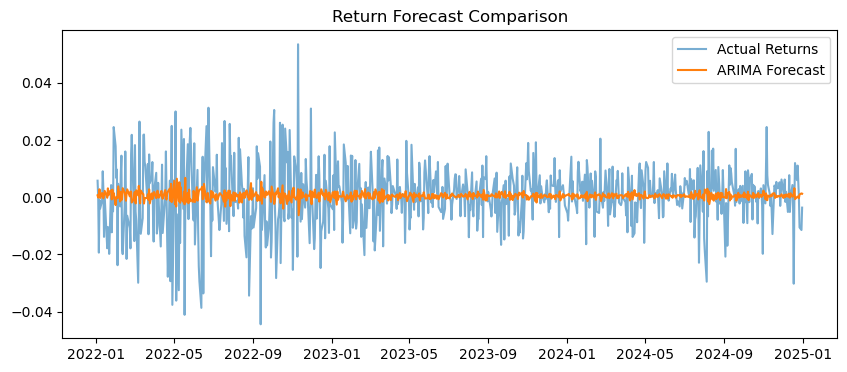

In [13]:
plt.figure(figsize=(10,4))
plt.plot(test_returns.index, test_returns, label="Actual Returns", alpha=0.6)
plt.plot(arima_forecasts.index, arima_forecasts, label="ARIMA Forecast")
plt.title("Return Forecast Comparison")
plt.legend()
plt.show()

## Volatility

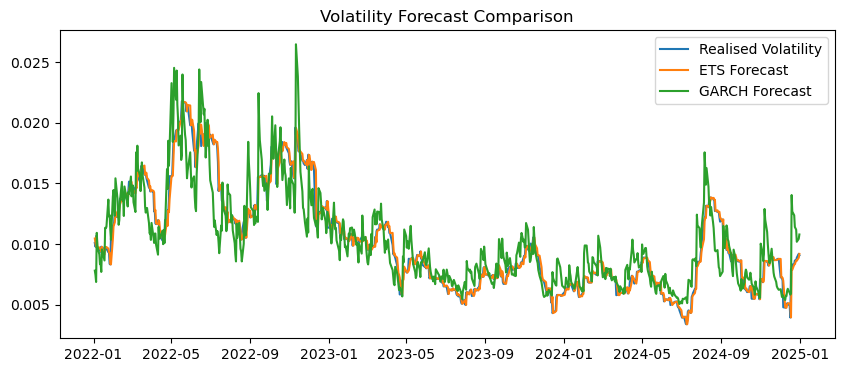

In [18]:
plt.figure(figsize=(10,4))
plt.plot(realised_vol.index, realised_vol, label="Realised Volatility")
plt.plot(ets_forecasts.index, ets_forecasts, label="ETS Forecast")
plt.plot(garch_forecasts.index, garch_forecasts, label="GARCH Forecast")
plt.title("Volatility Forecast Comparison")
plt.legend()
plt.savefig("../outputs/figures/volatility_forecast_comparison.png")
plt.show()

Volatility regimes are clearly visible, with GARCH responding more sharply to shocks.

# Synthesis

**Key findings**

+ Daily returns show minimal predictability across models

+ Volatility exhibits strong persistence and clustering

+ Simple benchmarks are difficult to beat at short horizons

+ GARCH captures conditional variance dynamics not visible in smoothing models

**Implications**

+ Return forecasts should not be used for directional trading

+ Volatility forecasts are suitable for risk monitoring

+ Model choice depends on decision context, not accuracy alone

# Limitations

Single asset

Short horizon

Normal error assumption in GARCH

Realised volatility is backward-looking

Transaction costs and implementability are not considered

# Save summary tables

In [15]:
return_results.to_csv("../outputs/tables/return_model_comparison.csv", index=False)
vol_results.to_csv("../outputs/tables/volatility_model_comparison.csv", index=False)